In [1]:
import os
import sys

import captum.attr as attr
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from typing import List, Dict


datapath = Path('/home/jseia/Desktop/thesis/data/')
csv_path = Path('/home/jseia/Desktop/thesis/code/stroke-seg/data/dataset.csv')
base_path = Path('/home/jseia/Desktop/thesis/code/nnUNet_ais/nnunetv2')
os.environ['nnUNet_raw'] = str(base_path/'nnUNet_raw')
os.environ['nnUNet_preprocessed'] = str(base_path/'preprocessed')
os.environ['nnUNet_results'] = str(base_path/'nnUNet_trained_models')

from ssl.model_interpreter import EmpeddingProjector, DimReductor, AttrGenerator
import ssl.plots as ssl_plots

sys.path.insert(0, '/home/jseia/Desktop/thesis/code/stroke-seg')
from dataset.dataset import StrokeDataset
sys.path.remove('/home/jseia/Desktop/thesis/code/stroke-seg')

dataset = StrokeDataset(
    datapath=datapath,
    datasets=['apis', 'aisd', 'tum', 'tbi'], 
    data_csv_path=csv_path,
    cases_to_exclude=[],
    pathology=['ais', 'normal'],
    modalities=['ncct', 'ncct-tilt'],
    partitions=['validation'],
    standard=['gold', 'silver', '-'],
    filter_discard=True
)

base_cfg_path = Path('/home/jseia/Desktop/thesis/code/nnUNet_ais/DeSD/cfg_files/ssl_pretrain/')
base_experiments_path = Path('/home/jseia/Desktop/thesis/experiments/')


def get_saliency_maps(exps_cfgs: List[Dict], dataset, force: bool = True):
    for exp_cfg in exps_cfgs:
        cfg_filename = f'config_{exp_cfg["data"]}_{exp_cfg["exp"]}.yml'
        exp_path = base_experiments_path / exp_cfg['data'] / exp_cfg["exp"]
        out_path = exp_path / 'attribution'
        if not out_path.exists() or force:
            saliency_gen = AttrGenerator(
                cfg_file_path=base_cfg_path/exp_cfg['data']/cfg_filename,
                chckpt_file_path=exp_path/'checkpoint.pth',
                device='cuda', method=attr.IntegratedGradients,
                layer=False, suffix='ig')
            subjects = dataset.df.loc[dataset.df.dataset_name != 'tum', 'subject'].unique().tolist()
            saliency_gen(subjects, save_saliency=True, out_path=out_path)


def get_projections(exps_cfgs: List[Dict], dataset, force: bool = True):
    for exp_cfg in tqdm(exps_cfgs):
        cfg_filename = f'config_{exp_cfg["data"]}_{exp_cfg["exp"]}.yml'
        exp_path = base_experiments_path / exp_cfg['data'] / exp_cfg["exp"]
        csv_path = exp_path/'complete_vol_embeddings.csv'
        if not csv_path.exists() or force:
            embedding_projector = EmpeddingProjector(
                cfg_file_path=base_cfg_path/exp_cfg['data']/cfg_filename,
                chckpt_file_path=exp_path/'checkpoint.pth',
                device='cuda', batch_size=1
            )
            embeddings = embedding_projector(dataset=dataset)
            embeddings['dataset'] = exp_cfg["data"]
            embeddings['context'] = exp_cfg["context"]
            embeddings.to_csv(csv_path)
        else:
            embeddings = pd.read_csv(csv_path, index_col=0)

        projections_csv_path = exp_path/'complete_vol_reductions.csv'
        if not projections_csv_path.exists() or force:
            projections = pd.DataFrame()
            for method in ['pca', 'tsne', 'umap']:
                method_kwargs = {'n_components': 2, 'random_state': 0}
                if method == 'tsne':
                    method_kwargs.update({'learning_rate': 'auto', 'init': 'pca'})
                reductor = DimReductor(method=method, method_kwargs=method_kwargs)
                method_projections = reductor(embeddings)
                meta_cols = [col for col in method_projections.columns if 'feat' not in col]
                projections[meta_cols] = method_projections[meta_cols].values
                projections[[f'{method}0', f'{method}1']] = method_projections[['feat0', 'feat1']].values
            projections['dataset'] = exp_cfg["data"]
            projections['context'] = exp_cfg["context"]
            projections.to_csv(projections_csv_path)
        else:
            projections = pd.read_csv(projections_csv_path, index_col=0)

In [2]:
exps_cfgs = [
    # {'data': 'nnunet_encoder', 'exp': 'tum', 'context': '-'},
    # {'data': 'nnunet_encoder', 'exp': 'non_tbi', 'context': '-'},
    {'data': 'all_ncct', 'exp': '001', 'context': '-'}, # No sym 
    {'data': 'all_ncct', 'exp': '004', 'context': 'sym'}, # Sym
    {'data': 'all_ncct', 'exp': '002', 'context': 'diff'}, # Diff
    {'data': 'non_tbi', 'exp': '001', 'context': '-'}, # No sym
    {'data': 'non_tbi', 'exp': '003', 'context': 'sym'}, # Sym
    {'data': 'non_tbi', 'exp': '004', 'context': 'diff'}, # Diff
    {'data': 'tbi', 'exp': '000', 'context': '-'}, # No sym
    {'data': 'tbi', 'exp': '001', 'context': 'sym'}, # Sym
    {'data': 'tbi', 'exp': '002', 'context': 'diff'}, # Diff
]   
get_saliency_maps(exps_cfgs, dataset)

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Using pretrained enconder: True
When initializing - The model has 100.0% of trainable parameters 


100%|██████████| 228/228 [48:36<00:00, 12.79s/it]


Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Using pretrained enconder: True
When initializing - The model has 100.0% of trainable parameters 


100%|██████████| 228/228 [45:03<00:00, 11.86s/it]


Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Using pretrained enconder: True
When initializing - The model has 100.0% of trainable parameters 


100%|██████████| 228/228 [56:15<00:00, 14.80s/it]


Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Using pretrained enconder: True
When initializing - The model has 100.0% of trainable parameters 


100%|██████████| 228/228 [46:42<00:00, 12.29s/it]


Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Using pretrained enconder: True
When initializing - The model has 100.0% of trainable parameters 


100%|██████████| 228/228 [44:56<00:00, 11.82s/it]


Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Using pretrained enconder: True
When initializing - The model has 100.0% of trainable parameters 


100%|██████████| 228/228 [53:35<00:00, 14.10s/it]


Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Using pretrained enconder: True
When initializing - The model has 100.0% of trainable parameters 


100%|██████████| 228/228 [1:00:04<00:00, 15.81s/it]


Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Using pretrained enconder: True
When initializing - The model has 100.0% of trainable parameters 


  6%|▌         | 13/228 [03:32<1:00:08, 16.78s/it]

In [3]:
# exps_cfgs = [
#     {'data': 'nnunet_encoder', 'exp': 'tum', 'context': '-'}, #FS TUM
#     {'data': 'nnunet_encoder', 'exp': 'non_tbi', 'context': '-'}, #FS NON-TBI
#     {'data': 'all_ncct', 'exp': '001', 'context': '-'}, # No sym 
#     {'data': 'all_ncct', 'exp': '004', 'context': 'sym'}, # Sym
#     {'data': 'all_ncct', 'exp': '002', 'context': 'diff'}, # Diff
#     {'data': 'non_tbi', 'exp': '001', 'context': '-'}, # No sym
#     {'data': 'non_tbi', 'exp': '003', 'context': 'sym'}, # Sym
#     {'data': 'non_tbi', 'exp': '004', 'context': 'diff'}, # Diff
#     {'data': 'tbi', 'exp': '000', 'context': '-'}, # No sym
#     {'data': 'tbi', 'exp': '001', 'context': 'sym'}, # Sym
#     {'data': 'tbi', 'exp': '002', 'context': 'diff'}, # Diff
# ]

# get_projections(exps_cfgs, dataset)

In [4]:
# %matplotlib inline
# exps_cfgs = [
#     {'data': 'all_ncct', 'exp': '001', 'context': '-'},
#     {'data': 'all_ncct', 'exp': '004', 'context': 'sym'},
#     {'data': 'all_ncct', 'exp': '002', 'context': 'diff'},
#     {'data': 'non_tbi', 'exp': '001', 'context': '-'},
#     {'data': 'non_tbi', 'exp': '003', 'context': 'sym'},
#     {'data': 'non_tbi', 'exp': '004', 'context': 'diff'},
#     {'data': 'tbi', 'exp': '000', 'context': '-'},
#     {'data': 'tbi', 'exp': '001', 'context': 'sym'},
#     {'data': 'tbi', 'exp': '002', 'context': 'diff'},
# ]

# preproc = False
# lims = [-5, 4] if preproc else [0, 80]
# scatter_examples_full(exps_cfgs, preproc, lims)

RuntimeError: Exception thrown in SimpleITK ReadImage: /src/SimpleElastix/Code/IO/src/sitkImageReaderBase.cxx:99:
sitk::ERROR: The file "/home/jseia/Desktop/thesis/experiments/all_ncct/004/attribution/3Xtd225_saliency_ig.nii.gz" does not exist.

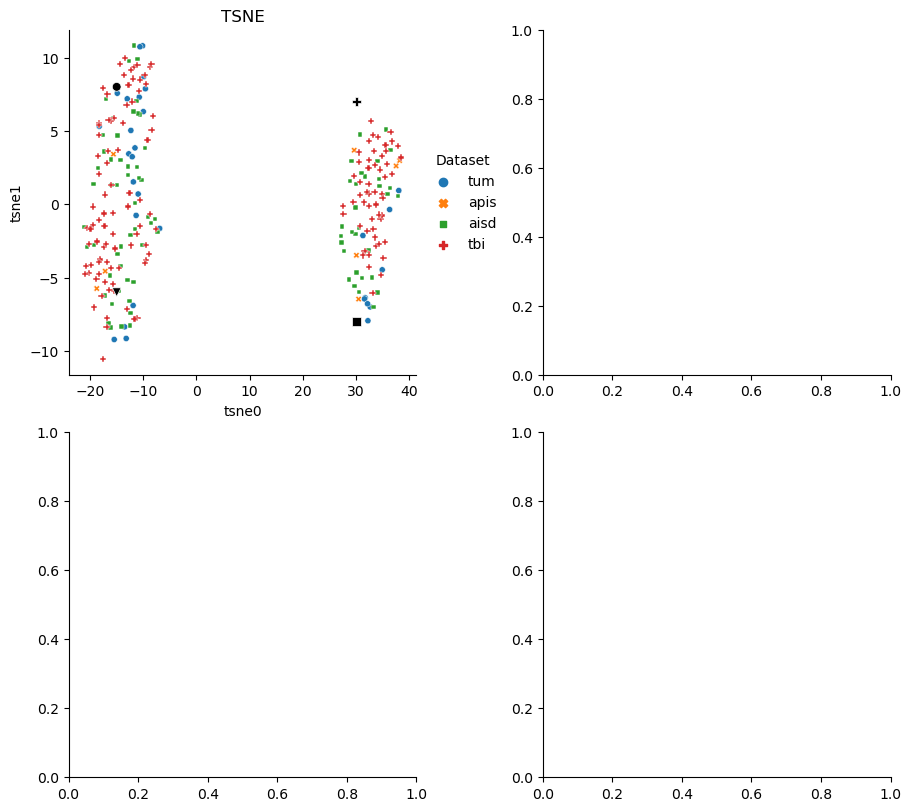

In [5]:
%matplotlib inline
exps_cfgs = [
    # {'data': 'all_ncct', 'exp': '001', 'context': '-',
    #  'centers': {
    #     'pca': [[-1, 0], [1, -2], [1.5, 2], [1.5, 0]],
    #     'tsne': [[-15, 8], [-15, -6], [30, -8], [30, 7]],
    #     'umap': [[-8, 5], [0, -5], [12, 6], [18, 5]]},
    # },
    {'data': 'all_ncct', 'exp': '004', 'context': 'sym',
     'centers': {'tsne': [[-15, 8], [-15, -6], [30, -8], [30, 7]]}},
    # {'data': 'all_ncct', 'exp': '002', 'context': 'diff',
    #  'centers': {'tsne': [[-10, 1.5], [8, -4.5], [12, 5], [20, -7.5]]}},
    # {'data': 'non_tbi', 'exp': '001', 'context': '-',
    #  'centers': {'tsne': [[-15, -2.5], [30, -5], [30, 2.5],[36, -3]]}},
    # {'data': 'non_tbi', 'exp': '003', 'context': 'sym',
    #  'centers': {'tsne': [[-15, -5], [-8,25], [24, -4], [15, 5]]}},
    # {'data': 'non_tbi', 'exp': '004', 'context': 'diff',
    #  'centers': {'tsne': [[-10, -5], [0,-12], [7, -12], [4, 13]]}},
    # {'data': 'tbi', 'exp': '000', 'context': '-',
    #  'centers': {'tsne': [[-27, -3], [-16, 5], [33, 2.5], [33, -5]]}},
    # {'data': 'tbi', 'exp': '001', 'context': 'sym',
    #  'centers': {'tsne': [[-10, -5], [3, -12], [5, 12], [13, 10]]}},
    # {'data': 'tbi', 'exp': '002', 'context': 'diff',
    #  'centers': {'tsne': [[-16, 5], [-10, 0], [0, 10], [5, -10]]}},
]

preproc = False
lims = [-5, 4] if preproc else [0, 80]
ssl_plots.scatter_examples_method(
    base_cfg_path, base_experiments_path, exps_cfgs, preproc, lims, 'tsne', plot_type=1, slice_criteria='middle')